In [1]:
from monai.utils import set_determinism
import torch
import matplotlib.pyplot as plt
import nrrd
import munch
import yaml

# set fixed seed for comparability
set_determinism(seed=0, additional_settings=None)

In [2]:
from trainer_own import LitModel
from datamodule_own import ASOCADataModule, CustomDataset

cwd = "/cluster/work/felixzr/TDT4265_StarterCode_2024/pytorch-lightning-template/"
config = munch.munchify(yaml.load(open(cwd + "config_copy.yaml"), Loader=yaml.FullLoader))

# model = LitModel.load_from_checkpoint(checkpoint_path="checkpoints/ASOCA/ASOCA_idun/best_model:epoch=32-val_acc=0.0000.ckpt", config=config)
# model = LitModel.load_from_checkpoint(checkpoint_path="checkpoints/ASOCA/ASOCA_idun/best_model:epoch=32-val_acc=0.0011.ckpt", config=config)
# model = LitModel.load_from_checkpoint(checkpoint_path="checkpoints/ASOCA/modelOnSpleen/best_model:epoch=77-val_acc=0.4738.ckpt", config=config)
# model = LitModel.load_from_checkpoint(checkpoint_path="checkpoints/ASOCA/ASOCA_idun/best_model:epoch=35-val_acc=0.0011.ckpt", config=config)
model = LitModel.load_from_checkpoint(checkpoint_path="/cluster/work/felixzr/TDT4265_StarterCode_2024/refactor_project/checkpoints/ASOCA/ASOCA_idun/best_model:epoch=62-val_acc=0.0000.ckpt", config=config)

model.eval() ## set to evaluation mode

/cluster/home/felixzr/.conda/envs/tdt4265/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: Error(s) in loading state_dict for LitModel:
	Missing key(s) in state_dict: "model.embeddings.0.proj.weight", "model.embeddings.0.proj.bias", "model.embeddings.0.conv0.conv_conv.0.weight", "model.embeddings.0.conv0.conv_conv.0.bias", "model.embeddings.0.conv0.conv_conv.0.running_mean", "model.embeddings.0.conv0.conv_conv.0.running_var", "model.embeddings.0.conv0.conv_conv.1.weight", "model.embeddings.0.conv0.conv_conv.2.weight", "model.embeddings.0.conv0.conv_conv.2.bias", "model.embeddings.0.conv0.conv_conv.3.weight", "model.embeddings.0.conv0.conv_conv.3.bias", "model.embeddings.0.conv0.conv_conv.3.running_mean", "model.embeddings.0.conv0.conv_conv.3.running_var", "model.embeddings.0.conv0.conv_conv.4.weight", "model.embeddings.0.conv0.conv_conv.6.weight", "model.embeddings.0.conv0.conv_conv.6.bias", "model.embeddings.0.conv1.conv_conv.0.weight", "model.embeddings.0.conv1.conv_conv.0.bias", "model.embeddings.0.conv1.conv_conv.0.running_mean", "model.embeddings.0.conv1.conv_conv.0.running_var", "model.embeddings.0.conv1.conv_conv.1.weight", "model.embeddings.0.conv1.conv_conv.2.weight", "model.embeddings.0.conv1.conv_conv.2.bias", "model.embeddings.0.conv1.conv_conv.3.weight", "model.embeddings.0.conv1.conv_conv.3.bias", "model.embeddings.0.conv1.conv_conv.3.running_mean", "model.embeddings.0.conv1.conv_conv.3.running_var", "model.embeddings.0.conv1.conv_conv.4.weight", "model.embeddings.0.conv1.conv_conv.6.weight", "model.embeddings.0.conv1.conv_conv.6.bias", "model.embeddings.0.down1.conv.0.weight", "model.embeddings.0.down1.conv.0.bias", "model.embeddings.0.down1.conv.0.running_mean", "model.embeddings.0.down1.conv.0.running_var", "model.embeddings.0.down1.conv.1.weight", "model.embeddings.0.down1.conv.2.weight", "model.embeddings.0.down1.conv.2.bias", "model.embeddings.0.down2.conv.0.weight", "model.embeddings.0.down2.conv.0.bias", "model.embeddings.0.down2.conv.0.running_mean", "model.embeddings.0.down2.conv.0.running_var", "model.embeddings.0.down2.conv.1.weight", "model.embeddings.0.down2.conv.2.weight", "model.embeddings.0.down2.conv.2.bias", "model.embeddings.1.proj.weight", "model.embeddings.1.proj.bias", "model.embeddings.1.conv0.conv_conv.0.weight", "model.embeddings.1.conv0.conv_conv.0.bias", "model.embeddings.1.conv0.conv_conv.0.running_mean", "model.embeddings.1.conv0.conv_conv.0.running_var", "model.embeddings.1.conv0.conv_conv.1.weight", "model.embeddings.1.conv0.conv_conv.2.weight", "model.embeddings.1.conv0.conv_conv.2.bias", "model.embeddings.1.conv0.conv_conv.3.weight", "model.embeddings.1.conv0.conv_conv.3.bias", "model.embeddings.1.conv0.conv_conv.3.running_mean", "model.embeddings.1.conv0.conv_conv.3.running_var", "model.embeddings.1.conv0.conv_conv.4.weight", "model.embeddings.1.conv0.conv_conv.6.weight", "model.embeddings.1.conv0.conv_conv.6.bias", "model.embeddings.1.conv1.conv_conv.0.weight", "model.embeddings.1.conv1.conv_conv.0.bias", "model.embeddings.1.conv1.conv_conv.0.running_mean", "model.embeddings.1.conv1.conv_conv.0.running_var", "model.embeddings.1.conv1.conv_conv.1.weight", "model.embeddings.1.conv1.conv_conv.2.weight", "model.embeddings.1.conv1.conv_conv.2.bias", "model.embeddings.1.conv1.conv_conv.3.weight", "model.embeddings.1.conv1.conv_conv.3.bias", "model.embeddings.1.conv1.conv_conv.3.running_mean", "model.embeddings.1.conv1.conv_conv.3.running_var", "model.embeddings.1.conv1.conv_conv.4.weight", "model.embeddings.1.conv1.conv_conv.6.weight", "model.embeddings.1.conv1.conv_conv.6.bias", "model.embeddings.1.down1.conv.0.weight", "model.embeddings.1.down1.conv.0.bias", "model.embeddings.1.down1.conv.0.running_mean", "model.embeddings.1.down1.conv.0.running_var", "model.embeddings.1.down1.conv.1.weight", "model.embeddings.1.down1.conv.2.weight", "model.embeddings.1.down1.conv.2.bias", "model.embeddings.1.down2.conv.0.weight", "model.embeddings.1.down2.conv.0.bias", "model.embeddings.1.down2.conv.0.running_mean", "model.embeddings.1.down2.conv.0.running_var", "model.embeddings.1.down2.conv.1.weight", "model.embeddings.1.down2.conv.2.weight", "model.embeddings.1.down2.conv.2.bias", "model.embeddings.2.proj.weight", "model.embeddings.2.proj.bias", "model.embeddings.2.conv0.conv_conv.0.weight", "model.embeddings.2.conv0.conv_conv.0.bias", "model.embeddings.2.conv0.conv_conv.0.running_mean", "model.embeddings.2.conv0.conv_conv.0.running_var", "model.embeddings.2.conv0.conv_conv.1.weight", "model.embeddings.2.conv0.conv_conv.2.weight", "model.embeddings.2.conv0.conv_conv.2.bias", "model.embeddings.2.conv0.conv_conv.3.weight", "model.embeddings.2.conv0.conv_conv.3.bias", "model.embeddings.2.conv0.conv_conv.3.running_mean", "model.embeddings.2.conv0.conv_conv.3.running_var", "model.embeddings.2.conv0.conv_conv.4.weight", "model.embeddings.2.conv0.conv_conv.6.weight", "model.embeddings.2.conv0.conv_conv.6.bias", "model.embeddings.2.conv1.conv_conv.0.weight", "model.embeddings.2.conv1.conv_conv.0.bias", "model.embeddings.2.conv1.conv_conv.0.running_mean", "model.embeddings.2.conv1.conv_conv.0.running_var", "model.embeddings.2.conv1.conv_conv.1.weight", "model.embeddings.2.conv1.conv_conv.2.weight", "model.embeddings.2.conv1.conv_conv.2.bias", "model.embeddings.2.conv1.conv_conv.3.weight", "model.embeddings.2.conv1.conv_conv.3.bias", "model.embeddings.2.conv1.conv_conv.3.running_mean", "model.embeddings.2.conv1.conv_conv.3.running_var", "model.embeddings.2.conv1.conv_conv.4.weight", "model.embeddings.2.conv1.conv_conv.6.weight", "model.embeddings.2.conv1.conv_conv.6.bias", "model.embeddings.2.down1.conv.0.weight", "model.embeddings.2.down1.conv.0.bias", "model.embeddings.2.down1.conv.0.running_mean", "model.embeddings.2.down1.conv.0.running_var", "model.embeddings.2.down1.conv.1.weight", "model.embeddings.2.down1.conv.2.weight", "model.embeddings.2.down1.conv.2.bias", "model.embeddings.2.down2.conv.0.weight", "model.embeddings.2.down2.conv.0.bias", "model.embeddings.2.down2.conv.0.running_mean", "model.embeddings.2.down2.conv.0.running_var", "model.embeddings.2.down2.conv.1.weight", "model.embeddings.2.down2.conv.2.weight", "model.embeddings.2.down2.conv.2.bias", "model.pyramid_ct.down3.conv.0.weight", "model.pyramid_ct.down3.conv.0.bias", "model.pyramid_ct.down3.conv.0.running_mean", "model.pyramid_ct.down3.conv.0.running_var", "model.pyramid_ct.down3.conv.1.weight", "model.pyramid_ct.down3.conv.2.weight", "model.pyramid_ct.down3.conv.2.bias", "model.pyramid_ct.down4.conv.0.weight", "model.pyramid_ct.down4.conv.0.bias", "model.pyramid_ct.down4.conv.0.running_mean", "model.pyramid_ct.down4.conv.0.running_var", "model.pyramid_ct.down4.conv.1.weight", "model.pyramid_ct.down4.conv.2.weight", "model.pyramid_ct.down4.conv.2.bias", "model.pyramid_ct.up3.up.0.weight", "model.pyramid_ct.up3.up.0.bias", "model.pyramid_ct.up3.up.0.running_mean", "model.pyramid_ct.up3.up.0.running_var", "model.pyramid_ct.up3.up.1.weight", "model.pyramid_ct.up3.up.2.weight", "model.pyramid_ct.up3.up.2.bias", "model.pyramid_ct.up3.conv.0.weight", "model.pyramid_ct.up3.conv.0.bias", "model.pyramid_ct.up3.conv.0.running_mean", "model.pyramid_ct.up3.conv.0.running_var", "model.pyramid_ct.up3.conv.1.weight", "model.pyramid_ct.up3.conv.2.weight", "model.pyramid_ct.up3.conv.2.bias", "model.pyramid_ct.up4.up.0.weight", "model.pyramid_ct.up4.up.0.bias", "model.pyramid_ct.up4.up.0.running_mean", "model.pyramid_ct.up4.up.0.running_var", "model.pyramid_ct.up4.up.1.weight", "model.pyramid_ct.up4.up.2.weight", "model.pyramid_ct.up4.up.2.bias", "model.pyramid_ct.up4.conv.0.weight", "model.pyramid_ct.up4.conv.0.bias", "model.pyramid_ct.up4.conv.0.running_mean", "model.pyramid_ct.up4.conv.0.running_var", "model.pyramid_ct.up4.conv.1.weight", "model.pyramid_ct.up4.conv.2.weight", "model.pyramid_ct.up4.conv.2.bias", "model.pyramid_ct.convtrans_e2.conv.conv_conv.0.weight", "model.pyramid_ct.convtrans_e2.conv.conv_conv.0.bias", "model.pyramid_ct.convtrans_e2.conv.conv_conv.0.running_mean", "model.pyramid_ct.convtrans_e2.conv.conv_conv.0.running_var", "model.pyramid_ct.convtrans_e2.conv.conv_conv.1.weight", "model.pyramid_ct.convtrans_e2.conv.conv_conv.2.weight", "model.pyramid_ct.convtrans_e2.conv.conv_conv.2.bias", "model.pyramid_ct.convtrans_e2.conv.conv_conv.3.weight", "model.pyramid_ct.convtrans_e2.conv.conv_conv.3.bias", "model.pyramid_ct.convtrans_e2.conv.conv_conv.3.running_mean", "model.pyramid_ct.convtrans_e2.conv.conv_conv.3.running_var", "model.pyramid_ct.convtrans_e2.conv.conv_conv.4.weight", "model.pyramid_ct.convtrans_e2.conv.conv_conv.6.weight", "model.pyramid_ct.convtrans_e2.conv.conv_conv.6.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.0.norm1.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.0.norm1.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.0.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_e2.trans.blocks.0.attn.relative_position_index", "model.pyramid_ct.convtrans_e2.trans.blocks.0.attn.qkv.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.0.attn.qkv.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.0.attn.proj.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.0.attn.proj.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.0.norm2.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.0.norm2.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.0.mlp.fc1.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.0.mlp.fc1.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.0.mlp.fc2.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.0.mlp.fc2.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.1.norm1.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.1.norm1.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.1.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_e2.trans.blocks.1.attn.relative_position_index", "model.pyramid_ct.convtrans_e2.trans.blocks.1.attn.qkv.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.1.attn.qkv.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.1.attn.proj.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.1.attn.proj.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.1.norm2.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.1.norm2.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.1.mlp.fc1.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.1.mlp.fc1.bias", "model.pyramid_ct.convtrans_e2.trans.blocks.1.mlp.fc2.weight", "model.pyramid_ct.convtrans_e2.trans.blocks.1.mlp.fc2.bias", "model.pyramid_ct.convtrans_e2.norm_layer.weight", "model.pyramid_ct.convtrans_e2.norm_layer.bias", "model.pyramid_ct.convtrans_d2.conv.conv_conv.0.weight", "model.pyramid_ct.convtrans_d2.conv.conv_conv.0.bias", "model.pyramid_ct.convtrans_d2.conv.conv_conv.0.running_mean", "model.pyramid_ct.convtrans_d2.conv.conv_conv.0.running_var", "model.pyramid_ct.convtrans_d2.conv.conv_conv.1.weight", "model.pyramid_ct.convtrans_d2.conv.conv_conv.2.weight", "model.pyramid_ct.convtrans_d2.conv.conv_conv.2.bias", "model.pyramid_ct.convtrans_d2.conv.conv_conv.3.weight", "model.pyramid_ct.convtrans_d2.conv.conv_conv.3.bias", "model.pyramid_ct.convtrans_d2.conv.conv_conv.3.running_mean", "model.pyramid_ct.convtrans_d2.conv.conv_conv.3.running_var", "model.pyramid_ct.convtrans_d2.conv.conv_conv.4.weight", "model.pyramid_ct.convtrans_d2.conv.conv_conv.6.weight", "model.pyramid_ct.convtrans_d2.conv.conv_conv.6.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.0.norm1.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.0.norm1.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.0.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_d2.trans.blocks.0.attn.relative_position_index", "model.pyramid_ct.convtrans_d2.trans.blocks.0.attn.qkv.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.0.attn.qkv.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.0.attn.proj.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.0.attn.proj.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.0.norm2.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.0.norm2.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.0.mlp.fc1.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.0.mlp.fc1.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.0.mlp.fc2.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.0.mlp.fc2.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.1.norm1.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.1.norm1.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.1.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_d2.trans.blocks.1.attn.relative_position_index", "model.pyramid_ct.convtrans_d2.trans.blocks.1.attn.qkv.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.1.attn.qkv.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.1.attn.proj.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.1.attn.proj.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.1.norm2.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.1.norm2.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.1.mlp.fc1.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.1.mlp.fc1.bias", "model.pyramid_ct.convtrans_d2.trans.blocks.1.mlp.fc2.weight", "model.pyramid_ct.convtrans_d2.trans.blocks.1.mlp.fc2.bias", "model.pyramid_ct.convtrans_d2.norm_layer.weight", "model.pyramid_ct.convtrans_d2.norm_layer.bias", "model.pyramid_ct.convtrans_e3.conv.conv_conv.0.weight", "model.pyramid_ct.convtrans_e3.conv.conv_conv.0.bias", "model.pyramid_ct.convtrans_e3.conv.conv_conv.0.running_mean", "model.pyramid_ct.convtrans_e3.conv.conv_conv.0.running_var", "model.pyramid_ct.convtrans_e3.conv.conv_conv.1.weight", "model.pyramid_ct.convtrans_e3.conv.conv_conv.2.weight", "model.pyramid_ct.convtrans_e3.conv.conv_conv.2.bias", "model.pyramid_ct.convtrans_e3.conv.conv_conv.3.weight", "model.pyramid_ct.convtrans_e3.conv.conv_conv.3.bias", "model.pyramid_ct.convtrans_e3.conv.conv_conv.3.running_mean", "model.pyramid_ct.convtrans_e3.conv.conv_conv.3.running_var", "model.pyramid_ct.convtrans_e3.conv.conv_conv.4.weight", "model.pyramid_ct.convtrans_e3.conv.conv_conv.6.weight", "model.pyramid_ct.convtrans_e3.conv.conv_conv.6.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.0.norm1.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.0.norm1.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.0.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_e3.trans.blocks.0.attn.relative_position_index", "model.pyramid_ct.convtrans_e3.trans.blocks.0.attn.qkv.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.0.attn.qkv.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.0.attn.proj.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.0.attn.proj.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.0.norm2.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.0.norm2.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.0.mlp.fc1.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.0.mlp.fc1.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.0.mlp.fc2.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.0.mlp.fc2.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.1.norm1.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.1.norm1.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.1.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_e3.trans.blocks.1.attn.relative_position_index", "model.pyramid_ct.convtrans_e3.trans.blocks.1.attn.qkv.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.1.attn.qkv.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.1.attn.proj.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.1.attn.proj.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.1.norm2.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.1.norm2.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.1.mlp.fc1.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.1.mlp.fc1.bias", "model.pyramid_ct.convtrans_e3.trans.blocks.1.mlp.fc2.weight", "model.pyramid_ct.convtrans_e3.trans.blocks.1.mlp.fc2.bias", "model.pyramid_ct.convtrans_e3.norm_layer.weight", "model.pyramid_ct.convtrans_e3.norm_layer.bias", "model.pyramid_ct.convtrans_d3.conv.conv_conv.0.weight", "model.pyramid_ct.convtrans_d3.conv.conv_conv.0.bias", "model.pyramid_ct.convtrans_d3.conv.conv_conv.0.running_mean", "model.pyramid_ct.convtrans_d3.conv.conv_conv.0.running_var", "model.pyramid_ct.convtrans_d3.conv.conv_conv.1.weight", "model.pyramid_ct.convtrans_d3.conv.conv_conv.2.weight", "model.pyramid_ct.convtrans_d3.conv.conv_conv.2.bias", "model.pyramid_ct.convtrans_d3.conv.conv_conv.3.weight", "model.pyramid_ct.convtrans_d3.conv.conv_conv.3.bias", "model.pyramid_ct.convtrans_d3.conv.conv_conv.3.running_mean", "model.pyramid_ct.convtrans_d3.conv.conv_conv.3.running_var", "model.pyramid_ct.convtrans_d3.conv.conv_conv.4.weight", "model.pyramid_ct.convtrans_d3.conv.conv_conv.6.weight", "model.pyramid_ct.convtrans_d3.conv.conv_conv.6.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.0.norm1.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.0.norm1.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.0.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_d3.trans.blocks.0.attn.relative_position_index", "model.pyramid_ct.convtrans_d3.trans.blocks.0.attn.qkv.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.0.attn.qkv.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.0.attn.proj.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.0.attn.proj.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.0.norm2.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.0.norm2.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.0.mlp.fc1.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.0.mlp.fc1.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.0.mlp.fc2.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.0.mlp.fc2.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.1.norm1.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.1.norm1.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.1.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_d3.trans.blocks.1.attn.relative_position_index", "model.pyramid_ct.convtrans_d3.trans.blocks.1.attn.qkv.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.1.attn.qkv.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.1.attn.proj.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.1.attn.proj.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.1.norm2.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.1.norm2.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.1.mlp.fc1.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.1.mlp.fc1.bias", "model.pyramid_ct.convtrans_d3.trans.blocks.1.mlp.fc2.weight", "model.pyramid_ct.convtrans_d3.trans.blocks.1.mlp.fc2.bias", "model.pyramid_ct.convtrans_d3.norm_layer.weight", "model.pyramid_ct.convtrans_d3.norm_layer.bias", "model.pyramid_ct.convtrans_e4.conv.conv_conv.0.weight", "model.pyramid_ct.convtrans_e4.conv.conv_conv.0.bias", "model.pyramid_ct.convtrans_e4.conv.conv_conv.0.running_mean", "model.pyramid_ct.convtrans_e4.conv.conv_conv.0.running_var", "model.pyramid_ct.convtrans_e4.conv.conv_conv.1.weight", "model.pyramid_ct.convtrans_e4.conv.conv_conv.2.weight", "model.pyramid_ct.convtrans_e4.conv.conv_conv.2.bias", "model.pyramid_ct.convtrans_e4.conv.conv_conv.3.weight", "model.pyramid_ct.convtrans_e4.conv.conv_conv.3.bias", "model.pyramid_ct.convtrans_e4.conv.conv_conv.3.running_mean", "model.pyramid_ct.convtrans_e4.conv.conv_conv.3.running_var", "model.pyramid_ct.convtrans_e4.conv.conv_conv.4.weight", "model.pyramid_ct.convtrans_e4.conv.conv_conv.6.weight", "model.pyramid_ct.convtrans_e4.conv.conv_conv.6.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.0.norm1.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.0.norm1.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.0.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_e4.trans.blocks.0.attn.relative_position_index", "model.pyramid_ct.convtrans_e4.trans.blocks.0.attn.qkv.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.0.attn.qkv.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.0.attn.proj.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.0.attn.proj.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.0.norm2.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.0.norm2.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.0.mlp.fc1.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.0.mlp.fc1.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.0.mlp.fc2.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.0.mlp.fc2.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.1.norm1.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.1.norm1.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.1.attn.relative_position_bias_table", "model.pyramid_ct.convtrans_e4.trans.blocks.1.attn.relative_position_index", "model.pyramid_ct.convtrans_e4.trans.blocks.1.attn.qkv.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.1.attn.qkv.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.1.attn.proj.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.1.attn.proj.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.1.norm2.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.1.norm2.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.1.mlp.fc1.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.1.mlp.fc1.bias", "model.pyramid_ct.convtrans_e4.trans.blocks.1.mlp.fc2.weight", "model.pyramid_ct.convtrans_e4.trans.blocks.1.mlp.fc2.bias", "model.pyramid_ct.convtrans_e4.norm_layer.weight", "model.pyramid_ct.convtrans_e4.norm_layer.bias", "model.pyramid_ct.out_conv2.conv.0.weight", "model.pyramid_ct.out_conv2.conv.0.bias", "model.pyramid_ct.out_conv2.conv.0.running_mean", "model.pyramid_ct.out_conv2.conv.0.running_var", "model.pyramid_ct.out_conv2.conv.1.weight", "model.pyramid_ct.out_conv2.conv.2.weight", "model.pyramid_ct.out_conv2.conv.2.bias", "model.pyramid_ct.out_conv3.conv.0.weight", "model.pyramid_ct.out_conv3.conv.0.bias", "model.pyramid_ct.out_conv3.conv.0.running_mean", "model.pyramid_ct.out_conv3.conv.0.running_var", "model.pyramid_ct.out_conv3.conv.1.weight", "model.pyramid_ct.out_conv3.conv.2.weight", "model.pyramid_ct.out_conv3.conv.2.bias", "model.pred_heads.0.up1.up.0.weight", "model.pred_heads.0.up1.up.0.bias", "model.pred_heads.0.up1.up.0.running_mean", "model.pred_heads.0.up1.up.0.running_var", "model.pred_heads.0.up1.up.1.weight", "model.pred_heads.0.up1.up.2.weight", "model.pred_heads.0.up1.up.2.bias", "model.pred_heads.0.up1.conv.0.weight", "model.pred_heads.0.up1.conv.0.bias", "model.pred_heads.0.up1.conv.0.running_mean", "model.pred_heads.0.up1.conv.0.running_var", "model.pred_heads.0.up1.conv.1.weight", "model.pred_heads.0.up1.conv.2.weight", "model.pred_heads.0.up1.conv.2.bias", "model.pred_heads.0.up2.up.0.weight", "model.pred_heads.0.up2.up.0.bias", "model.pred_heads.0.up2.up.0.running_mean", "model.pred_heads.0.up2.up.0.running_var", "model.pred_heads.0.up2.up.1.weight", "model.pred_heads.0.up2.up.2.weight", "model.pred_heads.0.up2.up.2.bias", "model.pred_heads.0.up2.conv.0.weight", "model.pred_heads.0.up2.conv.0.bias", "model.pred_heads.0.up2.conv.0.running_mean", "model.pred_heads.0.up2.conv.0.running_var", "model.pred_heads.0.up2.conv.1.weight", "model.pred_heads.0.up2.conv.2.weight", "model.pred_heads.0.up2.conv.2.bias", "model.pred_heads.0.conv0.conv_conv.0.weight", "model.pred_heads.0.conv0.conv_conv.0.bias", "model.pred_heads.0.conv0.conv_conv.0.running_mean", "model.pred_heads.0.conv0.conv_conv.0.running_var", "model.pred_heads.0.conv0.conv_conv.1.weight", "model.pred_heads.0.conv0.conv_conv.2.weight", "model.pred_heads.0.conv0.conv_conv.2.bias", "model.pred_heads.0.conv0.conv_conv.3.weight", "model.pred_heads.0.conv0.conv_conv.3.bias", "model.pred_heads.0.conv0.conv_conv.3.running_mean", "model.pred_heads.0.conv0.conv_conv.3.running_var", "model.pred_heads.0.conv0.conv_conv.4.weight", "model.pred_heads.0.conv0.conv_conv.6.weight", "model.pred_heads.0.conv0.conv_conv.6.bias", "model.pred_heads.0.conv1.conv_conv.0.weight", "model.pred_heads.0.conv1.conv_conv.0.bias", "model.pred_heads.0.conv1.conv_conv.0.running_mean", "model.pred_heads.0.conv1.conv_conv.0.running_var", "model.pred_heads.0.conv1.conv_conv.1.weight", "model.pred_heads.0.conv1.conv_conv.2.weight", "model.pred_heads.0.conv1.conv_conv.2.bias", "model.pred_heads.0.conv1.conv_conv.3.weight", "model.pred_heads.0.conv1.conv_conv.3.bias", "model.pred_heads.0.conv1.conv_conv.3.running_mean", "model.pred_heads.0.conv1.conv_conv.3.running_var", "model.pred_heads.0.conv1.conv_conv.4.weight", "model.pred_heads.0.conv1.conv_conv.6.weight", "model.pred_heads.0.conv1.conv_conv.6.bias", "model.pred_heads.0.out_conv0.conv.0.weight", "model.pred_heads.0.out_conv0.conv.0.bias", "model.pred_heads.0.out_conv0.conv.0.running_mean", "model.pred_heads.0.out_conv0.conv.0.running_var", "model.pred_heads.0.out_conv0.conv.1.weight", "model.pred_heads.0.out_conv0.conv.2.weight", "model.pred_heads.0.out_conv0.conv.2.bias", "model.pred_heads.0.out_conv1.conv.0.weight", "model.pred_heads.0.out_conv1.conv.0.bias", "model.pred_heads.0.out_conv1.conv.0.running_mean", "model.pred_heads.0.out_conv1.conv.0.running_var", "model.pred_heads.0.out_conv1.conv.1.weight", "model.pred_heads.0.out_conv1.conv.2.weight", "model.pred_heads.0.out_conv1.conv.2.bias", "model.pred_heads.1.up1.up.0.weight", "model.pred_heads.1.up1.up.0.bias", "model.pred_heads.1.up1.up.0.running_mean", "model.pred_heads.1.up1.up.0.running_var", "model.pred_heads.1.up1.up.1.weight", "model.pred_heads.1.up1.up.2.weight", "model.pred_heads.1.up1.up.2.bias", "model.pred_heads.1.up1.conv.0.weight", "model.pred_heads.1.up1.conv.0.bias", "model.pred_heads.1.up1.conv.0.running_mean", "model.pred_heads.1.up1.conv.0.running_var", "model.pred_heads.1.up1.conv.1.weight", "model.pred_heads.1.up1.conv.2.weight", "model.pred_heads.1.up1.conv.2.bias", "model.pred_heads.1.up2.up.0.weight", "model.pred_heads.1.up2.up.0.bias", "model.pred_heads.1.up2.up.0.running_mean", "model.pred_heads.1.up2.up.0.running_var", "model.pred_heads.1.up2.up.1.weight", "model.pred_heads.1.up2.up.2.weight", "model.pred_heads.1.up2.up.2.bias", "model.pred_heads.1.up2.conv.0.weight", "model.pred_heads.1.up2.conv.0.bias", "model.pred_heads.1.up2.conv.0.running_mean", "model.pred_heads.1.up2.conv.0.running_var", "model.pred_heads.1.up2.conv.1.weight", "model.pred_heads.1.up2.conv.2.weight", "model.pred_heads.1.up2.conv.2.bias", "model.pred_heads.1.conv0.conv_conv.0.weight", "model.pred_heads.1.conv0.conv_conv.0.bias", "model.pred_heads.1.conv0.conv_conv.0.running_mean", "model.pred_heads.1.conv0.conv_conv.0.running_var", "model.pred_heads.1.conv0.conv_conv.1.weight", "model.pred_heads.1.conv0.conv_conv.2.weight", "model.pred_heads.1.conv0.conv_conv.2.bias", "model.pred_heads.1.conv0.conv_conv.3.weight", "model.pred_heads.1.conv0.conv_conv.3.bias", "model.pred_heads.1.conv0.conv_conv.3.running_mean", "model.pred_heads.1.conv0.conv_conv.3.running_var", "model.pred_heads.1.conv0.conv_conv.4.weight", "model.pred_heads.1.conv0.conv_conv.6.weight", "model.pred_heads.1.conv0.conv_conv.6.bias", "model.pred_heads.1.conv1.conv_conv.0.weight", "model.pred_heads.1.conv1.conv_conv.0.bias", "model.pred_heads.1.conv1.conv_conv.0.running_mean", "model.pred_heads.1.conv1.conv_conv.0.running_var", "model.pred_heads.1.conv1.conv_conv.1.weight", "model.pred_heads.1.conv1.conv_conv.2.weight", "model.pred_heads.1.conv1.conv_conv.2.bias", "model.pred_heads.1.conv1.conv_conv.3.weight", "model.pred_heads.1.conv1.conv_conv.3.bias", "model.pred_heads.1.conv1.conv_conv.3.running_mean", "model.pred_heads.1.conv1.conv_conv.3.running_var", "model.pred_heads.1.conv1.conv_conv.4.weight", "model.pred_heads.1.conv1.conv_conv.6.weight", "model.pred_heads.1.conv1.conv_conv.6.bias", "model.pred_heads.1.out_conv0.conv.0.weight", "model.pred_heads.1.out_conv0.conv.0.bias", "model.pred_heads.1.out_conv0.conv.0.running_mean", "model.pred_heads.1.out_conv0.conv.0.running_var", "model.pred_heads.1.out_conv0.conv.1.weight", "model.pred_heads.1.out_conv0.conv.2.weight", "model.pred_heads.1.out_conv0.conv.2.bias", "model.pred_heads.1.out_conv1.conv.0.weight", "model.pred_heads.1.out_conv1.conv.0.bias", "model.pred_heads.1.out_conv1.conv.0.running_mean", "model.pred_heads.1.out_conv1.conv.0.running_var", "model.pred_heads.1.out_conv1.conv.1.weight", "model.pred_heads.1.out_conv1.conv.2.weight", "model.pred_heads.1.out_conv1.conv.2.bias", "model.pred_heads.2.up1.up.0.weight", "model.pred_heads.2.up1.up.0.bias", "model.pred_heads.2.up1.up.0.running_mean", "model.pred_heads.2.up1.up.0.running_var", "model.pred_heads.2.up1.up.1.weight", "model.pred_heads.2.up1.up.2.weight", "model.pred_heads.2.up1.up.2.bias", "model.pred_heads.2.up1.conv.0.weight", "model.pred_heads.2.up1.conv.0.bias", "model.pred_heads.2.up1.conv.0.running_mean", "model.pred_heads.2.up1.conv.0.running_var", "model.pred_heads.2.up1.conv.1.weight", "model.pred_heads.2.up1.conv.2.weight", "model.pred_heads.2.up1.conv.2.bias", "model.pred_heads.2.up2.up.0.weight", "model.pred_heads.2.up2.up.0.bias", "model.pred_heads.2.up2.up.0.running_mean", "model.pred_heads.2.up2.up.0.running_var", "model.pred_heads.2.up2.up.1.weight", "model.pred_heads.2.up2.up.2.weight", "model.pred_heads.2.up2.up.2.bias", "model.pred_heads.2.up2.conv.0.weight", "model.pred_heads.2.up2.conv.0.bias", "model.pred_heads.2.up2.conv.0.running_mean", "model.pred_heads.2.up2.conv.0.running_var", "model.pred_heads.2.up2.conv.1.weight", "model.pred_heads.2.up2.conv.2.weight", "model.pred_heads.2.up2.conv.2.bias", "model.pred_heads.2.conv0.conv_conv.0.weight", "model.pred_heads.2.conv0.conv_conv.0.bias", "model.pred_heads.2.conv0.conv_conv.0.running_mean", "model.pred_heads.2.conv0.conv_conv.0.running_var", "model.pred_heads.2.conv0.conv_conv.1.weight", "model.pred_heads.2.conv0.conv_conv.2.weight", "model.pred_heads.2.conv0.conv_conv.2.bias", "model.pred_heads.2.conv0.conv_conv.3.weight", "model.pred_heads.2.conv0.conv_conv.3.bias", "model.pred_heads.2.conv0.conv_conv.3.running_mean", "model.pred_heads.2.conv0.conv_conv.3.running_var", "model.pred_heads.2.conv0.conv_conv.4.weight", "model.pred_heads.2.conv0.conv_conv.6.weight", "model.pred_heads.2.conv0.conv_conv.6.bias", "model.pred_heads.2.conv1.conv_conv.0.weight", "model.pred_heads.2.conv1.conv_conv.0.bias", "model.pred_heads.2.conv1.conv_conv.0.running_mean", "model.pred_heads.2.conv1.conv_conv.0.running_var", "model.pred_heads.2.conv1.conv_conv.1.weight", "model.pred_heads.2.conv1.conv_conv.2.weight", "model.pred_heads.2.conv1.conv_conv.2.bias", "model.pred_heads.2.conv1.conv_conv.3.weight", "model.pred_heads.2.conv1.conv_conv.3.bias", "model.pred_heads.2.conv1.conv_conv.3.running_mean", "model.pred_heads.2.conv1.conv_conv.3.running_var", "model.pred_heads.2.conv1.conv_conv.4.weight", "model.pred_heads.2.conv1.conv_conv.6.weight", "model.pred_heads.2.conv1.conv_conv.6.bias", "model.pred_heads.2.out_conv0.conv.0.weight", "model.pred_heads.2.out_conv0.conv.0.bias", "model.pred_heads.2.out_conv0.conv.0.running_mean", "model.pred_heads.2.out_conv0.conv.0.running_var", "model.pred_heads.2.out_conv0.conv.1.weight", "model.pred_heads.2.out_conv0.conv.2.weight", "model.pred_heads.2.out_conv0.conv.2.bias", "model.pred_heads.2.out_conv1.conv.0.weight", "model.pred_heads.2.out_conv1.conv.0.bias", "model.pred_heads.2.out_conv1.conv.0.running_mean", "model.pred_heads.2.out_conv1.conv.0.running_var", "model.pred_heads.2.out_conv1.conv.1.weight", "model.pred_heads.2.out_conv1.conv.2.weight", "model.pred_heads.2.out_conv1.conv.2.bias". 
	Unexpected key(s) in state_dict: "model.model.0.conv.unit0.conv.weight", "model.model.0.conv.unit0.conv.bias", "model.model.0.conv.unit0.adn.N.weight", "model.model.0.conv.unit0.adn.N.bias", "model.model.0.conv.unit0.adn.N.running_mean", "model.model.0.conv.unit0.adn.N.running_var", "model.model.0.conv.unit0.adn.N.num_batches_tracked", "model.model.0.conv.unit0.adn.A.weight", "model.model.0.conv.unit1.conv.weight", "model.model.0.conv.unit1.conv.bias", "model.model.0.conv.unit1.adn.N.weight", "model.model.0.conv.unit1.adn.N.bias", "model.model.0.conv.unit1.adn.N.running_mean", "model.model.0.conv.unit1.adn.N.running_var", "model.model.0.conv.unit1.adn.N.num_batches_tracked", "model.model.0.conv.unit1.adn.A.weight", "model.model.0.residual.weight", "model.model.0.residual.bias", "model.model.1.submodule.0.conv.unit0.conv.weight", "model.model.1.submodule.0.conv.unit0.conv.bias", "model.model.1.submodule.0.conv.unit0.adn.N.weight", "model.model.1.submodule.0.conv.unit0.adn.N.bias", "model.model.1.submodule.0.conv.unit0.adn.N.running_mean", "model.model.1.submodule.0.conv.unit0.adn.N.running_var", "model.model.1.submodule.0.conv.unit0.adn.N.num_batches_tracked", "model.model.1.submodule.0.conv.unit0.adn.A.weight", "model.model.1.submodule.0.conv.unit1.conv.weight", "model.model.1.submodule.0.conv.unit1.conv.bias", "model.model.1.submodule.0.conv.unit1.adn.N.weight", "model.model.1.submodule.0.conv.unit1.adn.N.bias", "model.model.1.submodule.0.conv.unit1.adn.N.running_mean", "model.model.1.submodule.0.conv.unit1.adn.N.running_var", "model.model.1.submodule.0.conv.unit1.adn.N.num_batches_tracked", "model.model.1.submodule.0.conv.unit1.adn.A.weight", "model.model.1.submodule.0.residual.weight", "model.model.1.submodule.0.residual.bias", "model.model.1.submodule.1.submodule.0.conv.unit0.conv.weight", "model.model.1.submodule.1.submodule.0.conv.unit0.conv.bias", "model.model.1.submodule.1.submodule.0.conv.unit0.adn.N.weight", "model.model.1.submodule.1.submodule.0.conv.unit0.adn.N.bias", "model.model.1.submodule.1.submodule.0.conv.unit0.adn.N.running_mean", "model.model.1.submodule.1.submodule.0.conv.unit0.adn.N.running_var", "model.model.1.submodule.1.submodule.0.conv.unit0.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.0.conv.unit0.adn.A.weight", "model.model.1.submodule.1.submodule.0.conv.unit1.conv.weight", "model.model.1.submodule.1.submodule.0.conv.unit1.conv.bias", "model.model.1.submodule.1.submodule.0.conv.unit1.adn.N.weight", "model.model.1.submodule.1.submodule.0.conv.unit1.adn.N.bias", "model.model.1.submodule.1.submodule.0.conv.unit1.adn.N.running_mean", "model.model.1.submodule.1.submodule.0.conv.unit1.adn.N.running_var", "model.model.1.submodule.1.submodule.0.conv.unit1.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.0.conv.unit1.adn.A.weight", "model.model.1.submodule.1.submodule.0.residual.weight", "model.model.1.submodule.1.submodule.0.residual.bias", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit0.conv.weight", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit0.conv.bias", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit0.adn.N.weight", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit0.adn.N.bias", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit0.adn.N.running_mean", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit0.adn.N.running_var", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit0.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit0.adn.A.weight", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit1.conv.weight", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit1.conv.bias", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit1.adn.N.weight", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit1.adn.N.bias", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit1.adn.N.running_mean", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit1.adn.N.running_var", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit1.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.1.submodule.0.conv.unit1.adn.A.weight", "model.model.1.submodule.1.submodule.1.submodule.0.residual.weight", "model.model.1.submodule.1.submodule.1.submodule.0.residual.bias", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.conv.weight", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.conv.bias", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.adn.N.weight", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.adn.N.bias", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.adn.N.running_mean", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.adn.N.running_var", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.adn.A.weight", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.conv.weight", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.conv.bias", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.adn.N.weight", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.adn.N.bias", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.adn.N.running_mean", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.adn.N.running_var", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.adn.A.weight", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.residual.weight", "model.model.1.submodule.1.submodule.1.submodule.1.submodule.residual.bias", "model.model.1.submodule.1.submodule.1.submodule.2.0.conv.weight", "model.model.1.submodule.1.submodule.1.submodule.2.0.conv.bias", "model.model.1.submodule.1.submodule.1.submodule.2.0.adn.N.weight", "model.model.1.submodule.1.submodule.1.submodule.2.0.adn.N.bias", "model.model.1.submodule.1.submodule.1.submodule.2.0.adn.N.running_mean", "model.model.1.submodule.1.submodule.1.submodule.2.0.adn.N.running_var", "model.model.1.submodule.1.submodule.1.submodule.2.0.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.1.submodule.2.0.adn.A.weight", "model.model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.conv.weight", "model.model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.conv.bias", "model.model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.adn.N.weight", "model.model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.adn.N.bias", "model.model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.adn.N.running_mean", "model.model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.adn.N.running_var", "model.model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.adn.A.weight", "model.model.1.submodule.1.submodule.2.0.conv.weight", "model.model.1.submodule.1.submodule.2.0.conv.bias", "model.model.1.submodule.1.submodule.2.0.adn.N.weight", "model.model.1.submodule.1.submodule.2.0.adn.N.bias", "model.model.1.submodule.1.submodule.2.0.adn.N.running_mean", "model.model.1.submodule.1.submodule.2.0.adn.N.running_var", "model.model.1.submodule.1.submodule.2.0.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.2.0.adn.A.weight", "model.model.1.submodule.1.submodule.2.1.conv.unit0.conv.weight", "model.model.1.submodule.1.submodule.2.1.conv.unit0.conv.bias", "model.model.1.submodule.1.submodule.2.1.conv.unit0.adn.N.weight", "model.model.1.submodule.1.submodule.2.1.conv.unit0.adn.N.bias", "model.model.1.submodule.1.submodule.2.1.conv.unit0.adn.N.running_mean", "model.model.1.submodule.1.submodule.2.1.conv.unit0.adn.N.running_var", "model.model.1.submodule.1.submodule.2.1.conv.unit0.adn.N.num_batches_tracked", "model.model.1.submodule.1.submodule.2.1.conv.unit0.adn.A.weight", "model.model.1.submodule.2.0.conv.weight", "model.model.1.submodule.2.0.conv.bias", "model.model.1.submodule.2.0.adn.N.weight", "model.model.1.submodule.2.0.adn.N.bias", "model.model.1.submodule.2.0.adn.N.running_mean", "model.model.1.submodule.2.0.adn.N.running_var", "model.model.1.submodule.2.0.adn.N.num_batches_tracked", "model.model.1.submodule.2.0.adn.A.weight", "model.model.1.submodule.2.1.conv.unit0.conv.weight", "model.model.1.submodule.2.1.conv.unit0.conv.bias", "model.model.1.submodule.2.1.conv.unit0.adn.N.weight", "model.model.1.submodule.2.1.conv.unit0.adn.N.bias", "model.model.1.submodule.2.1.conv.unit0.adn.N.running_mean", "model.model.1.submodule.2.1.conv.unit0.adn.N.running_var", "model.model.1.submodule.2.1.conv.unit0.adn.N.num_batches_tracked", "model.model.1.submodule.2.1.conv.unit0.adn.A.weight", "model.model.2.0.conv.weight", "model.model.2.0.conv.bias", "model.model.2.0.adn.N.weight", "model.model.2.0.adn.N.bias", "model.model.2.0.adn.N.running_mean", "model.model.2.0.adn.N.running_var", "model.model.2.0.adn.N.num_batches_tracked", "model.model.2.0.adn.A.weight", "model.model.2.1.conv.unit0.conv.weight", "model.model.2.1.conv.unit0.conv.bias". 

In [ ]:
dm = ASOCADataModule(
    data_dir=config.data_dir,
    batch_size=1, #config.batch_size,
    num_workers=config.num_workers,
    train_split_ratio=config.train_split_ratio,
    data_root=config.data_root
)
dm.setup()
dataloader = dm.test_dataloader()

/cluster/home/felixzr/.conda/envs/tdt4265/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
device = "cuda"
model.to(device)

predictions = []
with torch.no_grad():
    for inputs in dataloader:
        # print("TEST")
        outputs = model.forward(inputs["sample"].to(device))
        predictions.append(outputs)

len(predictions)

1

In [ ]:
predictions[0].shape

torch.Size([1, 1, 512, 512, 224])

In [ ]:
# predictions[1].shape

In [ ]:
data, _ = nrrd.read("/cluster/work/felixzr/TDT4265_StarterCode_2024/data/ASOCA/Normal/CTCA/Normal_8.nrrd")
data_gt, _ = nrrd.read("/cluster/work/felixzr/TDT4265_StarterCode_2024/data/ASOCA/Normal/Annotations/Normal_8.nrrd")

data_gt.shape

(512, 512, 224)

In [ ]:
predictions_plot = predictions[0][0][0].cpu()

172

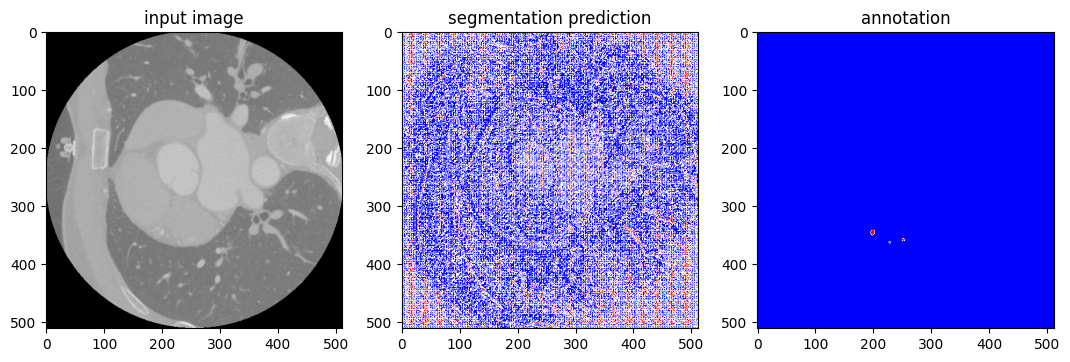

In [ ]:
import numpy as np
i = np.random.randint(data_gt.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(data[:, :, i], cmap="gray")

axs[1].set_title("segmentation prediction")
axs[1].imshow(predictions_plot[:,:,i], cmap="bwr")

axs[2].set_title("annotation")
axs[2].imshow(data_gt[:,:,i], cmap="bwr")

i

In [ ]:
torch.min(predictions[0]).item(), torch.max(predictions[0]).item(), torch.mean(predictions[0]).item(), torch.median(predictions[0]).item(), torch.std(predictions[0]).item()

(0.0, 1.0, 0.5105791687965393, 1.0, 0.4998880922794342)

In [53]:
predictions_plot

metatensor([[[1., 0., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 1.]],

        [[0., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         ...,
         [1., 1., 0.,  ..., 1., 0., 1.],
         [1., 1., 0.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 1., 1., 1.]],

        [[0., 1., 1.,  ..., 1., 0., 1.],
         [1., 0., 0.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 1., 0., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 0., 1., 0.],
         ...,
         [1., 1., 0.,  ..., 1., 0., 1.],
         [0., 1., 

In [ ]:
data_gt

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [64]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load("pretrained/best_metric_model_bak.pth"))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [65]:
predictions = []
with torch.no_grad():
    for inputs in dataloader:
        # print("TEST")
        outputs = model.forward(inputs["sample"].to(device))
        predictions.append(outputs)

len(predictions)

1

In [66]:
predictions_plot = predictions[0][0][0].cpu()

103

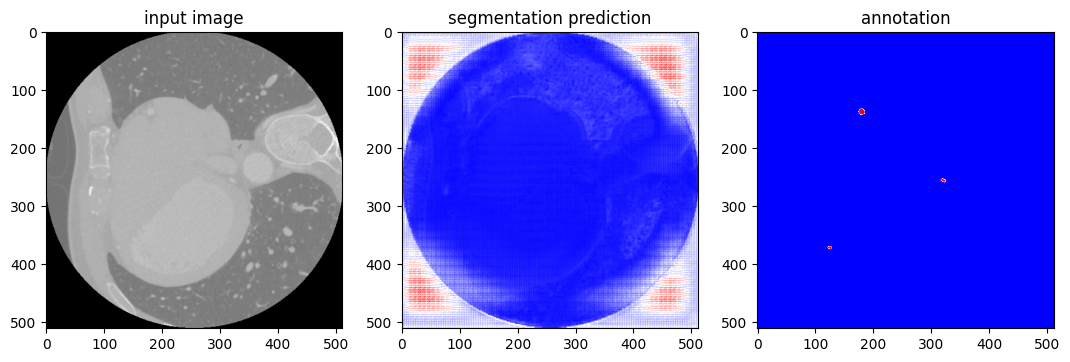

In [67]:
import numpy as np
i = np.random.randint(data_gt.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(data[:, :, i], cmap="gray")

axs[1].set_title("segmentation prediction")
axs[1].imshow(predictions_plot[:,:,i], cmap="bwr")

axs[2].set_title("annotation")
axs[2].imshow(data_gt[:,:,i], cmap="bwr")

i

In [68]:
torch.min(predictions[0]).item(), torch.max(predictions[0]).item(), torch.mean(predictions[0]).item(), torch.median(predictions[0]).item(), torch.std(predictions[0]).item()

(-99.01065826416016,
 123.93998718261719,
 1.306474208831787,
 1.8209376335144043,
 21.4716739654541)

In [54]:
from monai.utils import first
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt

In [55]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


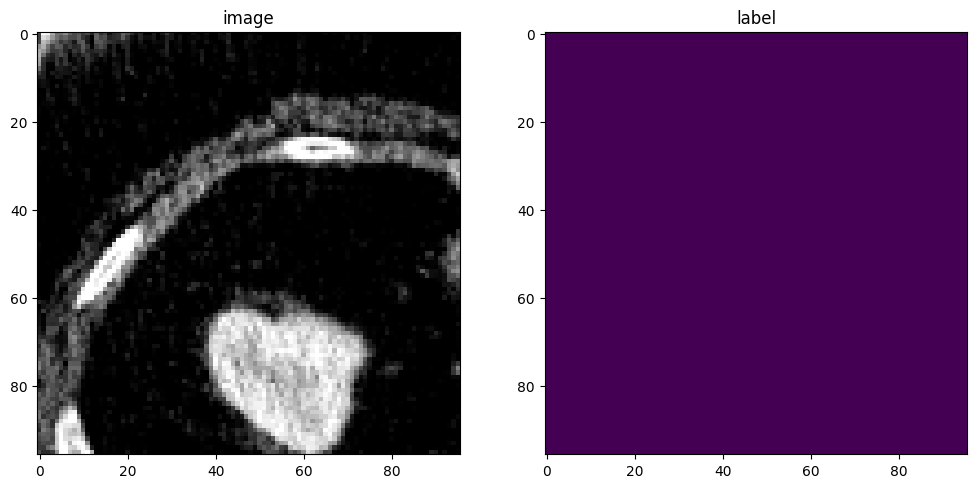

In [70]:
train_files = [{'image': '/cluster/work/felixzr/TDT4265_StarterCode_2024/pytorch-lightning-template/pretrained/Task09_Spleen/imagesTr/spleen_10.nii.gz', 'label': '/cluster/work/felixzr/TDT4265_StarterCode_2024/pytorch-lightning-template/pretrained/Task09_Spleen/labelsTr/spleen_10.nii.gz'}]

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()

In [71]:
prediction = model(check_data["image"].to(device)).to("cpu").detach()

70

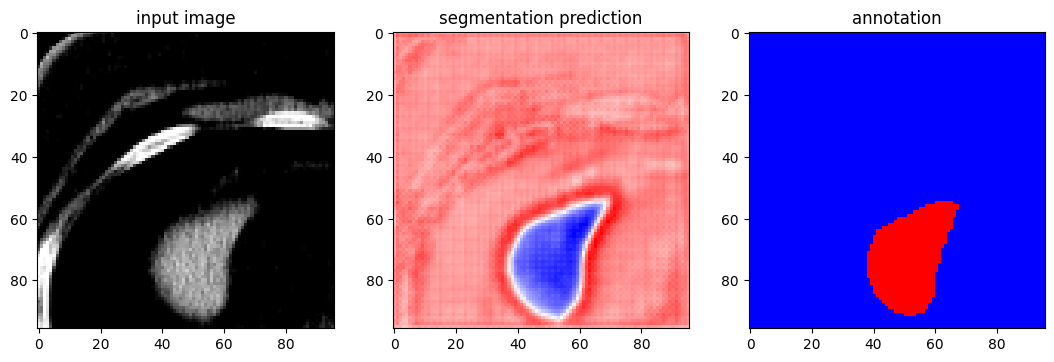

In [76]:
import numpy as np
i = np.random.randint(image.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(image[:, :, i], cmap="gray")

axs[1].set_title("segmentation prediction")
axs[1].imshow(prediction[0][0][:,:,i], cmap="bwr")

axs[2].set_title("annotation")
axs[2].imshow(label[:,:,i], cmap="bwr")

i

In [59]:
torch.min(prediction[0]).item(), torch.max(prediction[0]).item(), torch.mean(prediction[0]).item(), torch.median(prediction[0]).item(), torch.std(prediction[0]).item()

(0.0, 1.0, 0.5504297614097595, 1.0, 0.4974506199359894)

In [ ]:
check_data["image"].shape

# batch size, channels (1 means output 0 and 1), spatial dims

torch.Size([4, 1, 96, 96, 96])

In [77]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the .nii.gz file
img = nib.load('/cluster/work/felixzr/TDT4265_StarterCode_2024/pytorch-lightning-template/pretrained/out/spleen_11/spleen_11_seg.nii.gz')

# Get the image data as a NumPy array
img_data = img.get_fdata()

In [78]:
img_data.shape

(512, 512, 157, 2)

In [79]:
img_data[:,:,40,0].shape

(512, 512)

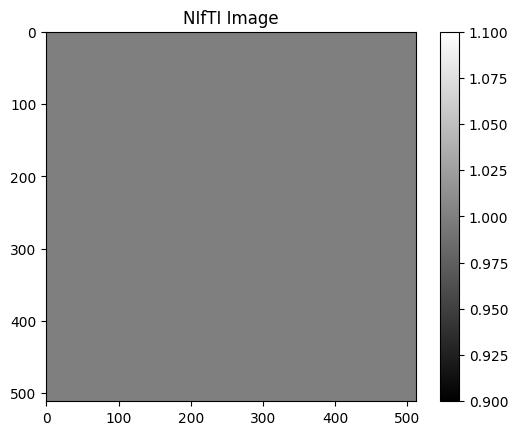

In [85]:
# Plot the image
plt.imshow(img_data[:,:,40,0], cmap='gray')  # Displaying a slice (change the index as needed)
plt.title('NIfTI Image')
plt.colorbar()
plt.show()